# Problem Statement

Consider a single measurement vector (SMV) linear regression model $${\bf y}={\bf X}\boldsymbol{\beta}+{\bf w}$$ where ${\bf X} \in \mathbb{R}^{n\times p} $ is a known design matrix and $\boldsymbol{\beta} \in \mathbb{R}^{p\times 1}$ is an unknown block sparse vector. The $p$ entries in $\boldsymbol{\beta}$ are divided into $p_b=p/l_b$ number of equal blocks with each block having $l_b$ number of entries.   The block support of $\boldsymbol{\beta}$ denoted by $\mathcal{S}_b=\{k:\boldsymbol{\beta}_k\neq {\bf 0}_{l_b}\}$ satisfies $k_b=cardinality(\mathcal{S}_b)\ll p_b$.  $\boldsymbol{\beta}_k$ for $k=1,\dotsc,p_b$ represents the kth block in $\boldsymbol{\beta}$.  ${\bf w} \in \mathbb{R}^{n\times 1}$ is a noise vector (for theoretical purposes only)  with each entries $\mathcal{N}(0,\sigma^2)$ distributed. 

The problem we address here is the estimation of $\boldsymbol{\beta}$ when $k_b$ and $\sigma^2$ are both unknown. We consider a high dimensional scenario where $n\ll p$. Under these constraints, it is difficult to estimate $\boldsymbol{\beta}$ and $ \mathcal{S}_b$ with finite sample guarantees.  Most (not all) popular sparse recovery algorithms including block OMP (also group OMP), group LASSO etc. can deliver estimation  with theoretical (especially restricted isometry property ) guarantees require $\textit{a priori}$ knowledge of $k_b$ and/or $\sigma^2$. Algorithms that does not require such a priori information are group square root LASSO, group SPICE, SBL etc. 

In our 2018 ICML paper http://proceedings.mlr.press/v80/kallummil18a.html we proposed residual ratio thresholding (RRT) as a tool to estimate $\boldsymbol{\beta}$ using OMP in a single measurement vector ($l_b=1$) without requiring $\textit{a priori}$ knowledge of sparsity and/or $\sigma^2$. This concept was later extended in a recent article (https://arxiv.org/pdf/1912.08637.pdf under review in IEEE TSP) to operate block OMP without requiring $\textit{a priori}$ knowledge of $k_b$ and/or $\sigma^2$.
Here, we illustrate  how to use RRT in this problem setting. 


# Concept  of RRT

Suppose we are given an ordered sequence of block support estimates $\mathcal{S}_1,\mathcal{S}_2...\mathcal{S}_{k_{max}}$ such that  a $card(\mathcal{S}_k)=k$ and $\mathcal{S}_k\subset \mathcal{S}_{k+1}$.  Corresponding to each support $\mathcal{S}_k$, one can compute the corresponding least squares residuals as ${\bf R}^k=({\bf I}_{n}-{\bf P}(\mathcal{S}_k)){\bf Y}$, where ${\bf P}(\mathcal{S}_k)$ is the projection onto the subspace spanned by the columns in ${\bf X}[:,true-support(\mathcal{S}_k)]$ and $true-support(\mathcal{S}_k)$ is the full support corresponding to the block support.  The corresponding residual ratios are defined as $$RR(k)=\dfrac{\|{\bf R}^k\|_2}{\|{\bf R}^{k-1}\|_2}$$. 

This statistic satisfies some interesting properties. For starters, $$0\leq RR(k)\leq 1$$

Under appropriate conditions on the matrix ${\bf X}$, SNR and sparsity $k_b$, many algorithms can generate support estimate sequences that satisfy $\mathcal{S}_{k_b}=\mathcal{S}_b$, the true unknown block support of $\boldsymbol{\beta}$. If those conditions are true then 

$$1). \ \ RR(k_b)\rightarrow 0  \ \text{as} \ \sigma^2\rightarrow 0$$.  

$$2). \ \ \mathbb{P}(RR(k)>\Gamma_{RRT}^{\alpha}(k),\ \text{for all} \ k=k_b+1,....k_{max})>1-\alpha$$

where $$\Gamma_{RRT}^{\alpha}(k)=\sqrt{F_{\dfrac{n-k l_b}{2},\dfrac{l_b}{2}}^{-1}\left(\dfrac{\alpha}{(p_b-k+1)kmax}\right)}$$
is a sequence of RRT thresholds. $F_{a,b}(x)$ is the CDF of a Beta random variable with parameters $a$ and $b$ and $F^{-1}$ is the inverse function of $F$.  

Properties 1 and 2 of $RR(k)$ means that the RRT estimate of sparsity given by $$k_{RRT}=\max\{k:RR(k)\leq \Gamma_{RRT}^{\alpha}(k)\}$$ will be equal to true unknown block sparsity $k_b$ and $\mathcal{S}_{k_{RRT}}$ will be equal to the true unknown support $\mathcal{S}_b$ at high enough SNR. 

# Usage
We follow the following conventions in codes.  (nfeatures=p,nsamples=n,block_size=$l_b$)

${\bf Given}$:  Y and X. We assume that X has unit $l_2$ norm columns. 

${\bf Step\ 1:}$ bsmv=block_single_measurement_vector()

${\bf Step\ 2:}$ estimate_support_dict=bsmv.compute_signal_and_support(X,Y,block_size=block_size,
                        algorithm='BOMP',alpha_list=[0.1])

${\bf Inputs: }$ algorithm has to be 'BOMP';
alpha_list=[$\alpha_1$,$\alpha_2$,...] the set of RRT thresholds $\alpha$ for which the estimates of $\boldsymbol{
\beta}$ and support $\mathcal{S}_b$ are to be computed. 

${\bf Outputs:}$  estimate_support_dict is a dictionary with keys $\alpha$ and values another dictionary dict. dict['support_estimate'] and dict['signal_estimate'] give the  estimates of $\mathcal{S}_b$ and $\boldsymbol{\beta}$ corresponding to the RRT threshold $\alpha$.

# How to use functions other than BOMP in  RRT framework. 

Any algorithm called 'Alg' that can deliver a block support estimate of the form $\mathcal{S}_k=Alg(X,Y,k)$ with $card(\mathcal{S}_k)=k$ can be used in RRT. Please construct a new function $$\text{res_ratio},\text{ordered_support_estimate_sequence}=\text{self.Alg_run()}$$
in codes/block_single_measurement_vector.py This can be achieved as follows. 


${\bf Step 1}$: Generate $\mathcal{S}_k=Alg(X,Y,k)$ for k=1,2,..,$k_{max}$. We typically set $k_{max}=\min\left(p_b,0.5(n+1)/l_b\right)$. 

${\bf Step 2:}$ The block support sequence generated by Alg may not be monotonically increasing, i.e., $\mathcal{S}_k\subset \mathcal{S}_{k+1}$. Convert non monotnic support sequence to monotonic support sequence 

    a). ordered_support_estimate_sequence= self.generate_ordered_sequence(block_support_estimate_sequence)
    
${\bf Step 3:}$  Generate residual ratios corresponding to the ordered_block_support_estimate_sequence. 

    a). res_ratios=self.res_ratios_from_ordered_sequence(ordered_support_estimate_sequence)
    


# Other utility functions

    1). X,Y,Beta,block_support,noisevar=bsmv.generate_random_example(nsamples=32,nfeatures=64,block_size=4,
                                                sparsity=3,SNR_db=20)
    
This function generates a linear regression model using Gaussian matrices which is further normalized to have $l_2$ columns, a block sparse vector with non zero entries randomly assigned $\pm1$  and Gaussian noise of noise variance determined by the required SNR. 

    2). support_error,l2_error=bsmv.compute_error(support_true,support_estimate,
                                                 Beta_true,Beta_estimate)
                                                
This function computes the support recovery error (=1 if support estimate!= support_true else 0) and $l_2$ error between $\boldsymbol{\beta}$ and its estimate.  

    3). block_support_est,Beta_est=bsmv.BOMP_prior_sparsity(X,Y,sparsity=len(block_support))
    
This function computes BOMP support estimate when provided with the apriori value of sparsity level $k_b$. Good baseline. 
                    

###  Example: Generate a block sparse regression problem


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from codes.block_single_measurement_vector import block_single_measurement_vector


In [2]:
bsmv=block_single_measurement_vector();
X,Y,Beta_true,block_support_true,noisevar=bsmv.generate_random_example(nsamples=64,nfeatures=128,block_size=4,
                                                                sparsity=3,SNR_db=20)
print('Unknown sparse vector Beta is')
print(Beta_true.flatten())
print('Support of Beta is')
print(block_support_true)

Unknown sparse vector Beta is
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1. -1. -1.  0.  0.  0.  0.
  1. -1.  1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Support of Beta is
[27, 28, 25]


### Example: RRT estimation

In [3]:
results_bomp_dict=bsmv.compute_signal_and_support(X=X,Y=Y,block_size=4,algorithm='BOMP',alpha_list=[0.1])
print('True_support')
print(block_support_true)
print('Estimated_support:BOMP')
print(results_bomp_dict[0.1]['support_estimate'])
Beta_est_bomp=results_bomp_dict[0.1]['signal_estimate']
np.squeeze(Beta_est_bomp)

True_support
[27, 28, 25]
Estimated_support:BOMP
[25, 28, 27]


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

# Evaluating performance. 

We compare the performance of BOMP operated using RRT against a simple baseline. A BOMP algorithm operated using a priori knowledge of sparsity $k_b$. Except at low SNR, BOMP operated using RRT matches the support aware oracle. In our papers, we compare RRT with BOMP  provided with noise variance also.  IN most of our experiments, we found that the performance GAP between BOMP with a priori known sparsity $k_b$ and noise variance and BOMP operate dusing RRT is minimal. 

In [4]:
SNR_db=np.linspace(0,30,10)
L2_ERROR_BOMP=np.zeros(10);L2_ERROR_BASELINE=np.zeros(10)
SUPPORT_ERROR_BOMP=np.zeros(10);SUPPORT_ERROR_BASELINE=np.zeros(10)
num_iter=1000; # number of montecarlo iterations for each example. 
nsamples=32;nfeatures=64;sparsity=3;block_size=4;


for s in np.arange(len(SNR_db)):
    snr_db=SNR_db[s]
    l2_error_bomp=0;l2_error_baseline=0;
    support_error_bomp=0;support_error_baseline=0;
    for num in np.arange(num_iter):
        X,Y,Beta_true,block_support_true,noisevar=bsmv.generate_random_example(nsamples=nsamples,nfeatures=nfeatures,
                                                                block_size=block_size,
                                                                sparsity=sparsity,SNR_db=snr_db)
        results_bomp_dict=bsmv.compute_signal_and_support(X=X,Y=Y,block_size=block_size,algorithm='BOMP',alpha_list=[0.1])
        block_support_estimate_bomp=results_bomp_dict[0.1]['support_estimate']
        Beta_est_bomp=results_bomp_dict[0.1]['signal_estimate']
        
        support_error,l2_error=bsmv.compute_error(block_support_true=block_support_true,
                                                  block_support_estimate=block_support_estimate_bomp,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_bomp)
        l2_error_bomp+=l2_error;support_error_bomp+=support_error
        
        block_support_estimate_baseline,Beta_est_baseline=bsmv.BOMP_prior_sparsity(X,Y,block_size=block_size,
                                                                                   sparsity=len(block_support_true))
        support_error,l2_error=bsmv.compute_error(block_support_true=block_support_true,
                                                 block_support_estimate=block_support_estimate_baseline,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_baseline)
        l2_error_baseline+=l2_error;support_error_baseline+=support_error;
        
    L2_ERROR_BOMP[s]=l2_error_bomp/num_iter;L2_ERROR_BASELINE[s]=l2_error_baseline/num_iter
    SUPPORT_ERROR_BOMP[s]=support_error_bomp/num_iter;
    SUPPORT_ERROR_BASELINE[s]=support_error_baseline/num_iter



Text(0, 0.5, 'support_recovery_error')

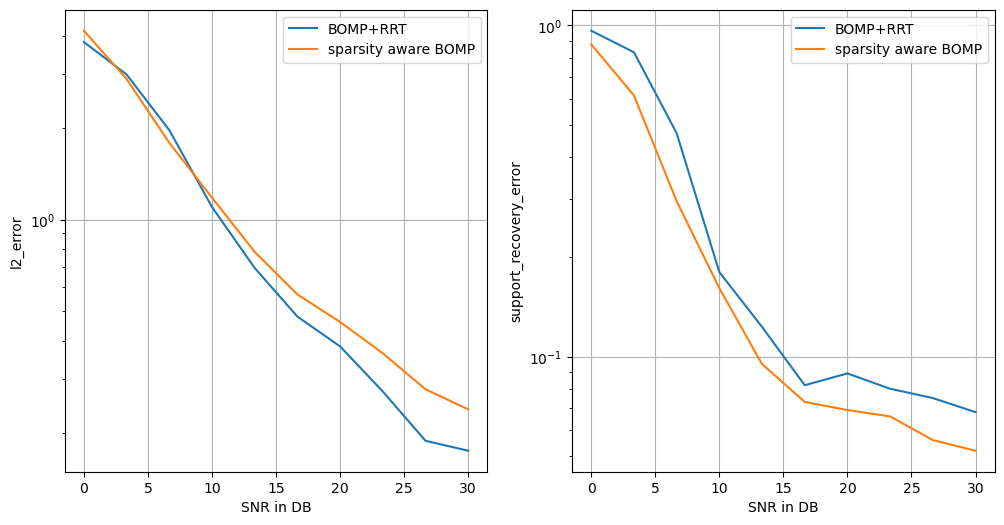

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(SNR_db,L2_ERROR_BOMP,label='BOMP+RRT')
plt.semilogy(SNR_db,L2_ERROR_BASELINE,label='sparsity aware BOMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('l2_error')  

plt.subplot(1,2,2)
plt.semilogy(SNR_db,SUPPORT_ERROR_BOMP,label='BOMP+RRT')
plt.semilogy(SNR_db,SUPPORT_ERROR_BASELINE,label='sparsity aware BOMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('support_recovery_error')  